## PREPARATION

In [32]:
import os
os.getcwd()

'C:\\Users\\tmn52\\Grid_Orientation\\validation_002'

In [1]:
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'S:\Grid_Ori_bigdata_008')

In [2]:
import os

import numpy as np
import pandas as pd

import rasterio as rio
import xarray as xr
import rioxarray as rxr

import geopandas as gpd

from rasterio.features import shapes

from sklearn.metrics import mean_squared_error

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks") # Ref: https://seaborn.pydata.org/tutorial/aesthetics.html

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For creating grid spec

In [3]:
main_dir = r"S:\Grid_Ori_bigdata_008"

In [4]:
save_dir = r"P:\Martin_publication\Grid_Orientation\Validation_Calibration_result"

---------------------------------------------------------------------------

## VALIDATION

#### 1. Get functions

In [5]:
# Ref: https://gis.stackexchange.com/questions/317391/python-extract-raster-values-at-point-locations
def point_raster_join(pts_df, path):
    '''A function is to get values from raster at the points'''
    coords = [(x, y) for x, y in zip(pts_df.x, pts_df.y)]
    mx_depth = rio.open(path)
    pts_list = [x[0] for x in mx_depth.sample(coords)]
    return pts_list

In [6]:
def get_dict(value_name, iterative_range, filename, observed_df):
    '''A function is to get values from multiple rasters at the points'''
    calibration_dict = {}
    # Looping to get data
    for i in range(len(iterative_range)):
        # Get dataframe
        path = fr"{main_dir}\\n_{n_calibration[i]}\\{filename}"
        calibration_df = observed_df.copy(deep=True)
        calibration_df[f'{value_name}'] = point_raster_join(calibration_df, path)
        calibration_df[f'{value_name}'] = calibration_df[f'{value_name}'].replace(-9999, np.nan)
        calibration_dict[f"n_{n_calibration[i]}"] = calibration_df[['level', f"{value_name}"]]
    return calibration_dict

#### 2. Get observed data

In [7]:
# Get observed data
obs_data_df = gpd.read_file(fr"{main_dir}\2005b_Flood.shp")
# Choose geometry and level
debris_df = obs_data_df[['geometry', 'X', 'Y', 'level_']]
# Rename
debris_df.rename(columns={'X':'x', 'Y':'y', 'level_':'level'}, inplace=True)
# Copy the dataframe and call it validation dataframe
validation_df = debris_df.copy(deep=True)

C:\Users\tmn52\AppData\Local\Temp\ipykernel_19156\4029149510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debris_df.rename(columns={'X':'x', 'Y':'y', 'level_':'level'}, inplace=True)


In [8]:
%%time
# Get level from model results
validation_df['mxe'] = point_raster_join(debris_df, fr"{main_dir}\test_nearest\out.mxe")

CPU times: total: 93.8 ms
Wall time: 144 ms


#### 3. Calculate errors

In [9]:
# Calculate the error
validation_df_copy = validation_df.copy(deep=True)
validation_df_copy['error'] = validation_df['mxe'] - validation_df_copy['level']

In [10]:
# Get avarge error and avarage absolute error
print(validation_df_copy['error'].mean())
print(validation_df_copy['error'].abs().mean())

-0.40890622854232805
0.5952812606096269


#### 4. Get plot

In [11]:
# Validate with mxe and rmse
validation_mxe_mse = mean_squared_error(validation_df.level, validation_df.mxe, squared=True)
validation_mxe_rmse = mean_squared_error(validation_df.level, validation_df.mxe, squared=False)

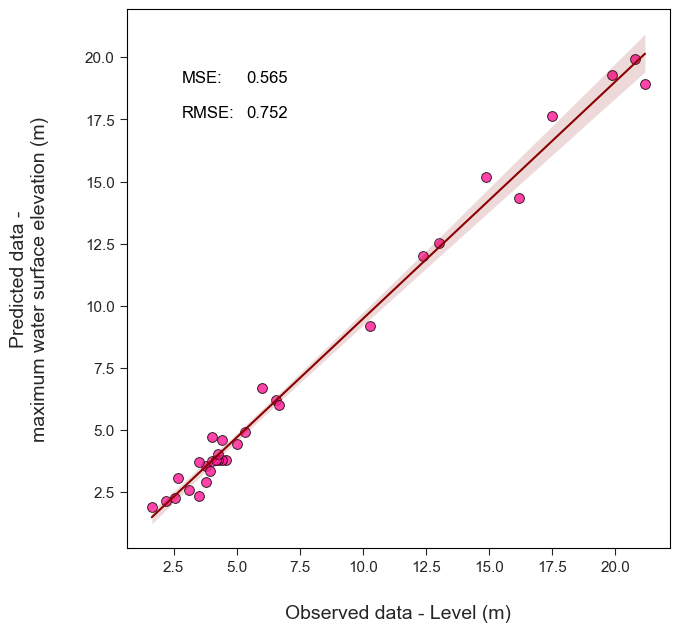

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))

# Size for title and label
fontsize = 14
labelpad = 21

# Plot
sns.regplot(x='level', y='mxe', data=validation_df,
            scatter_kws={"s": 50, 'edgecolor': 'black', 'color':'deeppink', 'linewidth':.7},
            line_kws={'color':'darkred', 'linewidth':1.5}, marker='o', ci=95, ax=ax)

# Adjust x and y labels
ax.set_xlabel("Observed data - Level (m)", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("Predicted data -\nmaximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

# Set up ticks
ax.set_yticks(np.arange(2.5, 21, 2.5))

# For frame
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-3)
ax.tick_params(direction='out', length=5, pad=labelpad-17)
    

title_error = "MSE:\n\nRMSE:"
error = f"{validation_mxe_mse:.3f}\n\n{validation_mxe_rmse:.3f}"

# Error added into the text
# Ref: https://github.com/matplotlib/matplotlib/issues/253/
#      https://stackoverflow.com/questions/67366092/valueerror-alignment-not-allowed-in-string-format-specifier-sometimes-not
#      https://stackoverflow.com/questions/8234445/format-output-string-right-alignment
ax.text(
    .1, .8, # Control the text on the x axis and y axis
    title_error,
    size=fontsize-2, ha='left', color='black', transform=ax.transAxes
)
ax.text(
    .22, .8, # Control the text on the x axis and y axis
    error,
    size=fontsize-2, ha='left', color='black', transform=ax.transAxes
)

plt.savefig(fr"{main_dir}\validation_result.jpg", bbox_inches='tight', dpi=350)
plt.savefig(fr"{save_dir}\validation_result.jpg", bbox_inches='tight', dpi=350)

---------------------------------------------------------------------

## CALIBRATION

#### 1. Get data

In [13]:
# Get range of calibration
n_calibration = np.round(np.arange(0.6, 2.6, 0.1), 1)

In [14]:
%%time
# Get dictionary of calibration results
n_dict = get_dict('mxe', n_calibration, 'out.mxe', debris_df)

CPU times: total: 2.89 s
Wall time: 4.09 s


#### 2. Counting NaNs

In [15]:
# Copy dictionary
import copy
n_dict_copy_001 = copy.deepcopy(n_dict)

In [16]:
# Counting NaNs
num_missing_values = []
for i in range(len(n_calibration)):
    nan_num = n_dict_copy_001[f"n_{n_calibration[i]}"].mxe.isna().sum()
    text = "n = {0} has {1} missing values".format(n_calibration[i], nan_num)
    num_missing_values.append(nan_num)
    print(text)

n = 0.6 has 24 missing values
n = 0.7 has 21 missing values
n = 0.8 has 18 missing values
n = 0.9 has 15 missing values
n = 1.0 has 14 missing values
n = 1.1 has 14 missing values
n = 1.2 has 13 missing values
n = 1.3 has 12 missing values
n = 1.4 has 10 missing values
n = 1.5 has 9 missing values
n = 1.6 has 9 missing values
n = 1.7 has 9 missing values
n = 1.8 has 8 missing values
n = 1.9 has 8 missing values
n = 2.0 has 7 missing values
n = 2.1 has 6 missing values
n = 2.2 has 4 missing values
n = 2.3 has 3 missing values
n = 2.4 has 3 missing values
n = 2.5 has 3 missing values


Text(0, 0.5, 'Missing values')

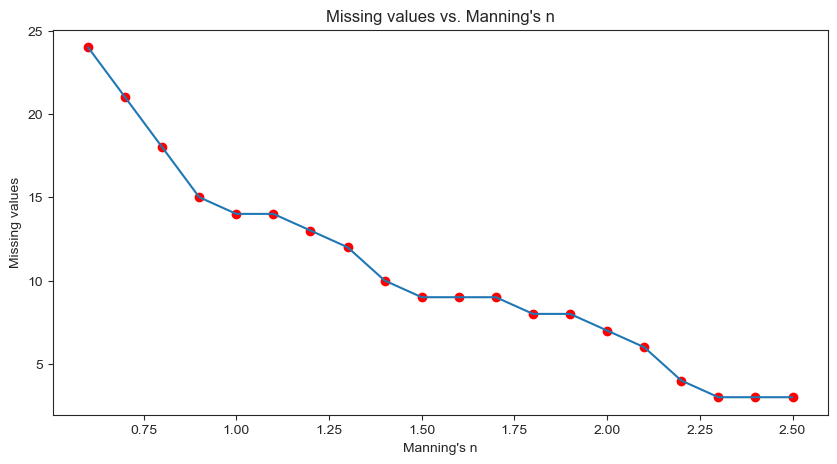

In [17]:
# Plot missing values
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x=n_calibration, y=num_missing_values, c='red')
ax.plot(n_calibration, num_missing_values) # For line
ax.set_title("Missing values vs. Manning's n")
ax.set_xlabel("Manning's n")
ax.set_ylabel("Missing values")

#### 3. Get errors

In [18]:
# Copy dictionary
n_dict_copy_002 = copy.deepcopy(n_dict)

##### First method

In [19]:
n_mxe = pd.DataFrame()
for i in range(len(n_calibration)):
    n_mxe[f'n_mxe_{n_calibration[i]}'] = n_dict_copy_002[f'n_{n_calibration[i]}'].mxe

In [20]:
n_mxe

,n_mxe_0.6,n_mxe_0.7,n_mxe_0.8,n_mxe_0.9,n_mxe_1.0,n_mxe_1.1,n_mxe_1.2,n_mxe_1.3,n_mxe_1.4,n_mxe_1.5,n_mxe_1.6,n_mxe_1.7,n_mxe_1.8,n_mxe_1.9,n_mxe_2.0,n_mxe_2.1,n_mxe_2.2,n_mxe_2.3,n_mxe_2.4,n_mxe_2.5
0,NaN,1.855000,1.969000,2.072000,2.149000,2.215,2.286000,2.352000,2.413000,2.470000,2.522000,2.568000,2.609000,2.647000,2.679000,2.707000,2.731000,2.753000,2.773000,2.791
1,1.796000,1.957000,2.073000,2.175000,2.255000,2.323,2.394000,2.463000,2.527000,2.586000,2.640000,2.689000,2.731000,2.769000,2.802000,2.830000,2.854000,2.876000,2.895000,2.914
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.245000,2.370000,2.483000,2.577000,2.656,2.733000,2.811000,2.883000,2.949000,3.010000,3.066000,3.114000,3.157000,3.193000,3.224000,3.252000,3.275000,3.296000,3.315
4,NaN,NaN,NaN,NaN,1.910000,1.972,2.042000,2.109000,2.171000,2.228000,2.280000,2.325000,2.365000,2.401000,2.432000,2.458000,2.481000,2.502000,2.520000,2.538
5,2.363000,2.545000,2.683000,2.808000,2.914000,3.005,3.092000,3.180000,3.262000,3.338000,3.409000,3.473000,3.530000,3.579000,3.621000,3.657000,3.688000,3.715000,3.739000,3.761
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.580000,3.630000,3.672000,3.709000,3.741000,3.768000,3.792000,3.814
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.601000,4.631000,4.655000,4.676
8,NaN,NaN,3.545000,3.670000,3.783000,3.880,3.974000,4.066000,4.153000,4.234000,4.309000,4.380000,4.441000,4.493000,4.537000,4.575000,4.607000,4.635000,4.659000,4.681
9,NaN,4.036000,4.181000,4.313000,4.429000,4.528,4.622000,4.723000,4.820000,4.911000,4.995000,5.070000,5.137000,5.198000,5.251000,5.296000,5.335000,5.369000,5.399000,5.425


In [21]:
# Get indices of not nan rows
notnan_inds = pd.notnull(n_mxe).all(1).to_numpy().nonzero()
# Convert to list
notnan_inds_list = np.array(notnan_inds).tolist()[0]

In [22]:
# Get no missing data dictionary
n_nomissing_dict = {}
for i in range(len(n_calibration)):
    n_nomissing_dict[f"n_{n_calibration[i]}"] = n_dict_copy_002[f"n_{n_calibration[i]}"].loc[notnan_inds_list, :]

In [23]:
# Generate RMSE without missing values
rmse_selectedmissing_list = []
for i in range(len(n_calibration)):
    rmse = mean_squared_error(
        n_nomissing_dict[f"n_{n_calibration[i]}"].level, 
        n_nomissing_dict[f"n_{n_calibration[i]}"].mxe, 
        squared=False
    )
    rmse_selectedmissing_list.append(rmse)
    text = "RMSE when n = {0} is {1:.3f}".format(n_calibration[i], rmse_selectedmissing_list[i])
    print(text)

RMSE when n = 0.6 is 1.261
RMSE when n = 0.7 is 1.122
RMSE when n = 0.8 is 1.005
RMSE when n = 0.9 is 0.904
RMSE when n = 1.0 is 0.817
RMSE when n = 1.1 is 0.742
RMSE when n = 1.2 is 0.676
RMSE when n = 1.3 is 0.617
RMSE when n = 1.4 is 0.569
RMSE when n = 1.5 is 0.534
RMSE when n = 1.6 is 0.512
RMSE when n = 1.7 is 0.504
RMSE when n = 1.8 is 0.508
RMSE when n = 1.9 is 0.520
RMSE when n = 2.0 is 0.540
RMSE when n = 2.1 is 0.563
RMSE when n = 2.2 is 0.589
RMSE when n = 2.3 is 0.616
RMSE when n = 2.4 is 0.644
RMSE when n = 2.5 is 0.673


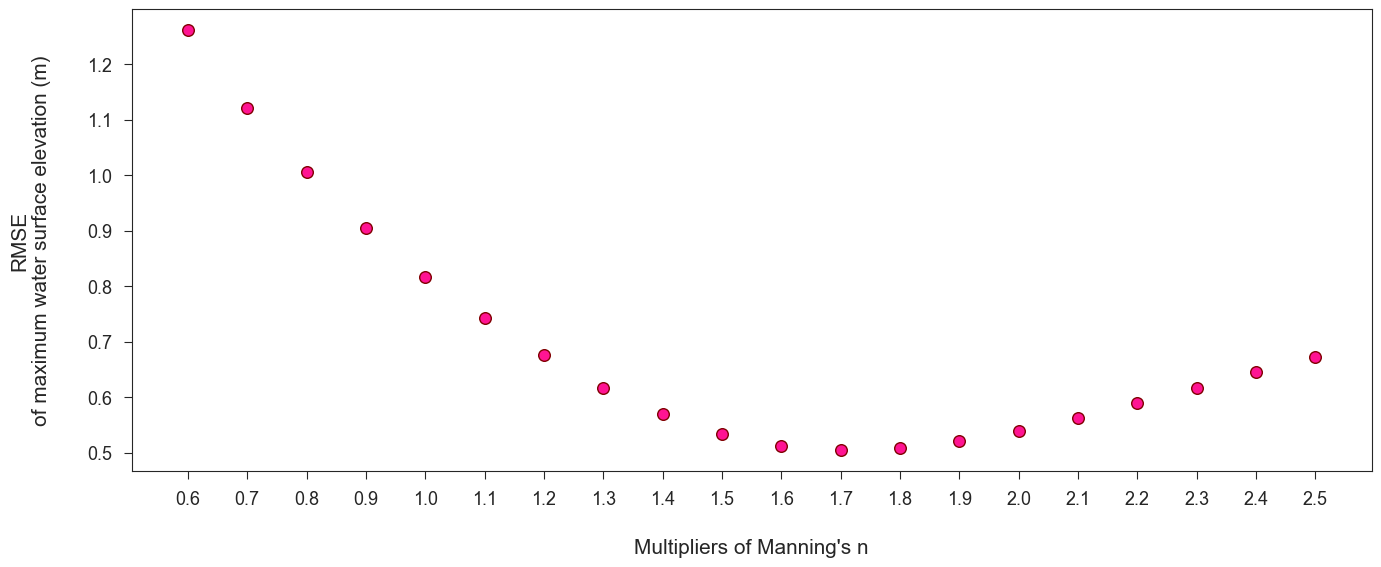

In [24]:
# No connected lines
fig, ax = plt.subplots(figsize=(16, 6))

fontsize = 15
labelpad = 21

# Plot
ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax.set_xticks(np.arange(.6, 2.6, .1))
# ax.set_yticks(np.arange(.3, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# Save
# plt.savefig(fr"{main_dir}\calibration_noconnectedline.png", bbox_inches='tight', dpi=330)

##### Second method

In [25]:
# Get no missing data dictionary
n_nomissing_dict = {}
for i in range(len(n_calibration)):
    n_nomissing_dict[f"n_{n_calibration[i]}"] = n_dict_copy_002[f"n_{n_calibration[i]}"][n_dict_copy_002['n_0.6'].mxe.notnull()]

In [26]:
# Generate RMSE without missing values
rmse_selectedmissing_list = []
for i in range(len(n_calibration)):
    rmse = mean_squared_error(
        n_nomissing_dict[f"n_{n_calibration[i]}"][n_nomissing_dict[f"n_{n_calibration[i]}"].mxe.notnull()].level, 
        n_nomissing_dict[f"n_{n_calibration[i]}"][n_nomissing_dict[f"n_{n_calibration[i]}"].mxe.notnull()].mxe, 
        squared=False
    )
    rmse_selectedmissing_list.append(rmse)
    text = "RMSE when n = {0} is {1:.3f}".format(n_calibration[i], rmse_selectedmissing_list[i])
    print(text)

RMSE when n = 0.6 is 1.261
RMSE when n = 0.7 is 1.122
RMSE when n = 0.8 is 1.005
RMSE when n = 0.9 is 0.904
RMSE when n = 1.0 is 0.817
RMSE when n = 1.1 is 0.742
RMSE when n = 1.2 is 0.676
RMSE when n = 1.3 is 0.617
RMSE when n = 1.4 is 0.569
RMSE when n = 1.5 is 0.534
RMSE when n = 1.6 is 0.512
RMSE when n = 1.7 is 0.504
RMSE when n = 1.8 is 0.508
RMSE when n = 1.9 is 0.520
RMSE when n = 2.0 is 0.540
RMSE when n = 2.1 is 0.563
RMSE when n = 2.2 is 0.589
RMSE when n = 2.3 is 0.616
RMSE when n = 2.4 is 0.644
RMSE when n = 2.5 is 0.673


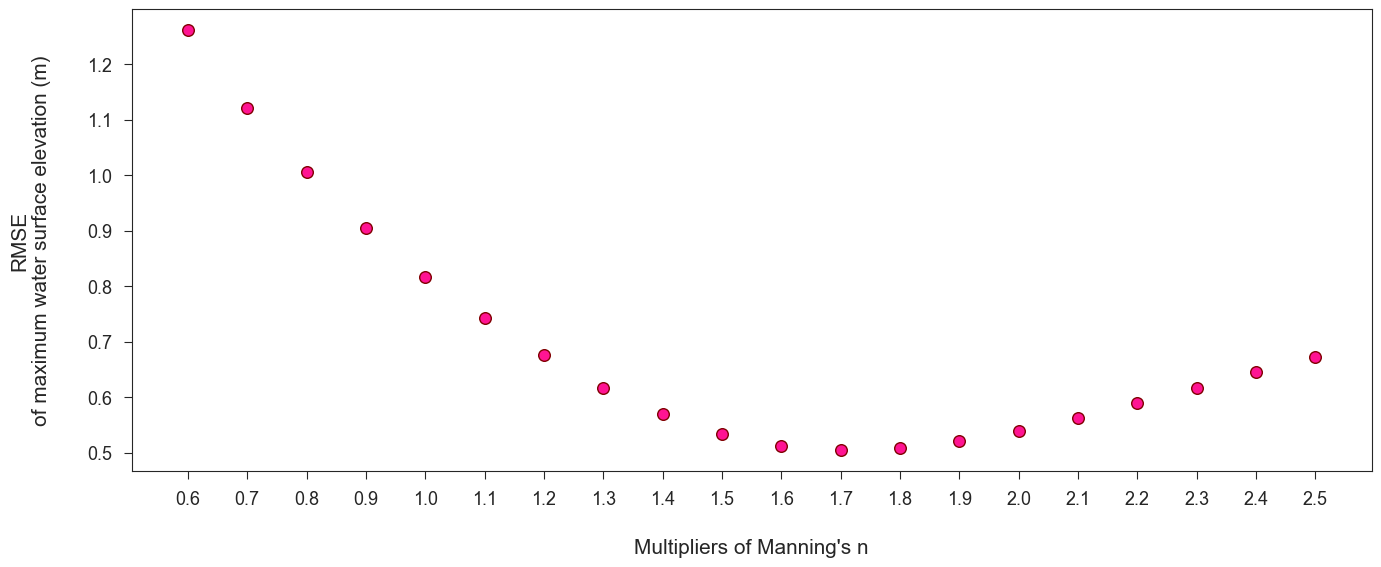

In [27]:
# No connected lines
fig, ax = plt.subplots(figsize=(16, 6))

fontsize = 15
labelpad = 21

# Plot
ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax.set_xticks(np.arange(.6, 2.6, .1))
# ax.set_yticks(np.arange(.6, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# Save
# plt.savefig(fr"{main_dir}\calibration_noconnectedline2.png", bbox_inches='tight', dpi=330)

------------------------------------------------------------

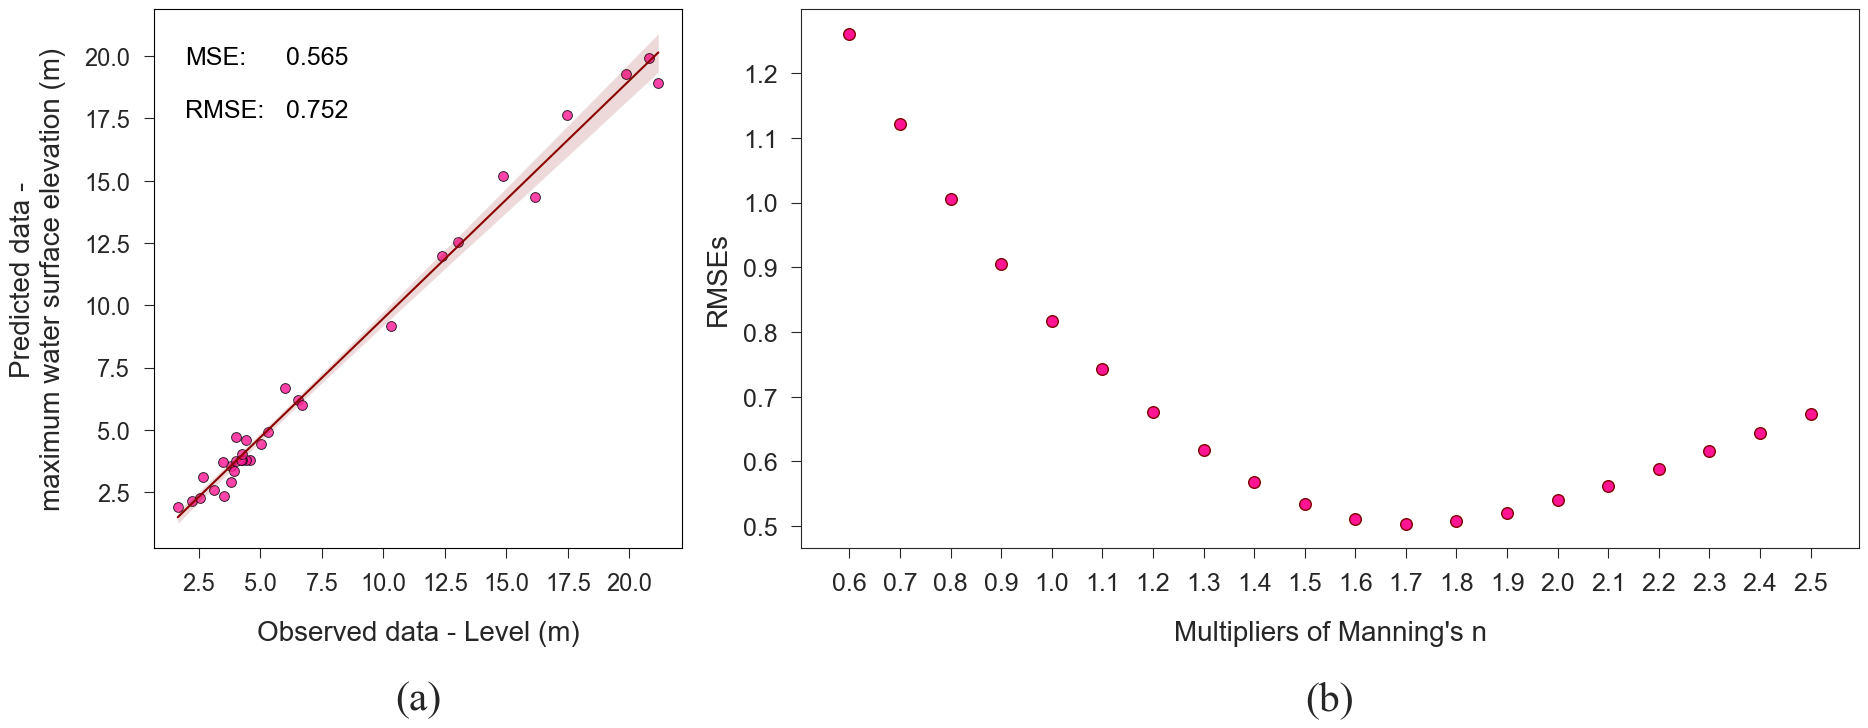

In [31]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(22, 7), gridspec_kw={'width_ratios': [1, 2]})

plt.subplots_adjust(wspace=.15)

# Size for title and label
fontsize = 20
labelpad = 18

# Plot
sns.regplot(x='level', y='mxe', data=validation_df,
            scatter_kws={"s": 50, 'edgecolor': 'black', 'color':'deeppink', 'linewidth':.7},
            line_kws={'color':'darkred', 'linewidth':1.5}, marker='o', ci=95, ax=ax[0])

# Adjust x and y labels
ax[0].set_xlabel("Observed data - Level (m)", fontsize=fontsize, labelpad=labelpad)
ax[0].set_ylabel("Predicted data -\nmaximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad-5)

# Set up ticks
ax[0].set_yticks(np.arange(2.5, 21, 2.5))

# For frame
for spine in ax[0].spines.values():
    spine.set_edgecolor('black')
    
# Set up ticks
for item in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-3)
ax[0].tick_params(direction='out', length=7, pad=labelpad-8)
    

title_error = "MSE:\n\nRMSE:"
error = f"{validation_mxe_mse:.3f}\n\n{validation_mxe_rmse:.3f}"

# Error added into the text
# Ref: https://github.com/matplotlib/matplotlib/issues/253/
#      https://stackoverflow.com/questions/67366092/valueerror-alignment-not-allowed-in-string-format-specifier-sometimes-not
#      https://stackoverflow.com/questions/8234445/format-output-string-right-alignment
ax[0].text(
    .06, .8, # Control the text on the x axis and y axis
    title_error,
    size=fontsize-2, ha='left', color='black', transform=ax[0].transAxes
)
ax[0].text(
    .25, .8, # Control the text on the x axis and y axis
    error,
    size=fontsize-2, ha='left', color='black', transform=ax[0].transAxes
)

# Caption
font = {'fontname': 'Times New Roman'}
ax[0].text(.5, -.28, '(a)', fontsize=30, 
             horizontalalignment='center', verticalalignment='center', linespacing=9.5, **font, transform=ax[0].transAxes)




# Plot
ax[1].scatter(x=n_calibration, y=rmse_selectedmissing_list, 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax[1].set_xticks(np.arange(.6, 2.6, .1))
# ax.set_yticks(np.arange(.3, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax[1].set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax[1].set_ylabel("RMSEs", rotation=-270, fontsize=fontsize, labelpad=labelpad-10)

    
# Set up ticks
for item in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax[1].tick_params(direction='out', length=7, pad=labelpad-8)

# Caption
font = {'fontname': 'Times New Roman'}
ax[1].text(.5, -.28, '(b)', fontsize=30, 
             horizontalalignment='center', verticalalignment='center', linespacing=9.5, **font, transform=ax[1].transAxes)

# Save
plt.savefig(fr"{main_dir}\validation_calibration.jpg", bbox_inches='tight', dpi=350)
plt.savefig(fr"{save_dir}\validation_calibration.jpg", bbox_inches='tight', dpi=350)

--------------------------------------------------------------------------------------